# Parameter scan

<img src="img/splitter.png" alt="diagram" width="400"/>

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FParameterScan.ipynb).

In this notebook, we will show an example of using tidy3d to evaluate device performance over a set of many design parameters.

This example will also provide a walkthrough of Tidy3D's [Job](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.web.container.Job.html) and [Batch](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.web.container.Batch.html) features for managing both individual simulations and sets of simulations.

For demonstration, we look at the splitting ratio of a directional coupler as we vary the coupling length between two waveguides. The sidewall of the waveguides is slanted, deviating from the vertical direction by `sidewall_angle`.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import os
import gdspy

# tidy3D imports
import tidy3d as td
from tidy3d import web

# set tidy3d to only print error information to reduce verbosity
td.config.logging_level = 'error'

## Setup

First we set up some global parameters

In [2]:
# wavelength / frequency
lambda0 = 1.550                     # all length scales in microns
freq0 = td.constants.C_0 / lambda0
fwidth = freq0 / 10

# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
mat_wg = td.Medium(permittivity=wg_n**2)
mat_sub = td.Medium(permittivity=sub_n**2)

# Waveguide dimensions

# Waveguide height
wg_height = 0.22
# Waveguide width
wg_width = 0.45
# Waveguide separation in the beginning/end
wg_spacing_in = 8
# Angle of the sidewall deviating from the vertical ones, positive values for the base larger than the top
sidewall_angle = np.pi/6
# Total device length along propagation direction
device_length = 100
# Length of the bend region
bend_length = 16
# space between waveguide and PML
pml_spacing = 1
# resolution control: minimum number of grid cells per wavelength in each material
grid_cells_per_wvl = 16

### Define waveguide bends and coupler

Here is where we define our directional coupler shape programmatically in terms of the geometric parameters

In [3]:
def bend_pts(bend_length, width, npts=10):
    """ Set of points describing a tanh bend from (0, 0) to (length, width)"""
    x = np.linspace(0, bend_length, npts)
    y = width*(1 + np.tanh(6*(x/bend_length - 0.5)))/2
    return np.stack((x, y), axis=1)

def arm_pts(length, width, coup_length, bend_length, npts_bend=30):
    """ Set of points defining one arm of an integrated coupler """
    ### Make the right half of the coupler arm first
    # Make bend and offset by coup_length/2
    bend = bend_pts(bend_length, width, npts_bend)
    bend[:, 0] += coup_length / 2
    # Add starting point as (0, 0)
    right_half = np.concatenate(([[0, 0]], bend))
    # Add an extra point to make sure waveguide is straight past the bend
    right_half = np.concatenate((right_half, [[right_half[-1, 0] + 0.1, width]]))
    # Add end point as (length/2, width)
    right_half = np.concatenate((right_half, [[length/2, width]]))

    # Make the left half by reflecting and omitting the (0, 0) point
    left_half = np.copy(right_half)[1:, :]
    left_half[:, 0] = -left_half[::-1, 0]
    left_half[:, 1] = left_half[::-1, 1]
    
    return np.concatenate((left_half, right_half), axis=0)

def make_coupler(
    length, 
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length,
    npts_bend=30):
    """ Make an integrated coupler using the gdspy FlexPath object. """

    # Compute one arm of the coupler
    arm_width = (wg_spacing_in - wg_width - wg_spacing_coup)/2
    arm = arm_pts(length, arm_width, coup_length, bend_length, npts_bend)
    # Reflect and offset bottom arm
    coup_bot = np.copy(arm)
    coup_bot[:, 1] = -coup_bot[::-1, 1] - wg_width/2 - wg_spacing_coup/2
    # Offset top arm
    coup_top = np.copy(arm)
    coup_top[:, 1] += wg_width/2 + wg_spacing_coup/2
    
    # Create waveguides as GDS paths
    path_bot = gdspy.FlexPath(coup_bot, wg_width, layer=1, datatype=0)
    path_top = gdspy.FlexPath(coup_top, wg_width, layer=1, datatype=1)
    
    return [path_bot, path_top]

### Create Simulation and Submit Job

The following function creates a tidy3d simulation object for a set of design parameters.

Note that the simulation has not been run yet, just created.

In [4]:
def make_sim(coup_length, wg_spacing_coup, domain_field=False):
    """ Make a simulation with a given length of the coupling region and
    distance between the waveguides in that region. If ``domain_field``
    is True, a 2D in-plane field monitor will be added.
    """
    
    gdspy.current_library = gdspy.GdsLibrary()
    lib = gdspy.GdsLibrary()

    # Geometry must be placed in GDS cells to import into Tidy3D
    coup_cell = lib.new_cell('Coupler')

    substrate = gdspy.Rectangle(
        (-device_length/2, -wg_spacing_in/2-10),
        (device_length/2, wg_spacing_in/2+10),
        layer=0)
    coup_cell.add(substrate)

    # Add the coupler to a gdspy cell
    gds_coup = make_coupler(
        device_length,
        wg_spacing_in,
        wg_width,
        wg_spacing_coup,
        coup_length,
        bend_length)
    coup_cell.add(gds_coup)

    # Substrate
    [oxide_geo] = td.PolySlab.from_gds(
        gds_cell=coup_cell,
        gds_layer=0,
        gds_dtype=0,
        slab_bounds=(-10, 0),
        axis=2)
    
    oxide = td.Structure(
        geometry=oxide_geo,
        medium=mat_sub)
        
    # Waveguides (import all datatypes if gds_dtype not specified)
    coupler1_geo, coupler2_geo = td.PolySlab.from_gds(
        gds_cell=coup_cell,
        gds_layer=1,
        slab_bounds=(0, wg_height),
        sidewall_angle=sidewall_angle,
        axis=2)
    
    coupler1 = td.Structure(
        geometry=coupler1_geo,
        medium=mat_wg
    )
    
    coupler2 = td.Structure(
        geometry=coupler2_geo,
        medium=mat_wg
    )
    
    # Simulation size along propagation direction
    sim_length = 2 + 2*bend_length + coup_length

    # Spacing between waveguides and PML
    sim_size = [
        sim_length,
        wg_spacing_in + wg_width + 2*pml_spacing,
        wg_height + 2*pml_spacing]


    # source
    src_pos = -sim_length/2 + 0.5
    msource = td.ModeSource(
        center=[src_pos , wg_spacing_in / 2 , wg_height / 2],
        size=[0, 3, 2],
        source_time = td.GaussianPulse(
            freq0=freq0,
            fwidth=fwidth),
        direction='+',
        mode_spec=td.ModeSpec(),
        mode_index=0,
    )

    mon_in = td.ModeMonitor(
        center=[(src_pos + 0.5), wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        mode_spec=td.ModeSpec(),
        name='in')
    mon_ref_bot = td.ModeMonitor(
        center=[(src_pos + 0.5), -wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        mode_spec=td.ModeSpec(),
        name='refect_bottom')
    mon_top = td.ModeMonitor(
        center=[-(src_pos + 0.5), wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        mode_spec=td.ModeSpec(),
        name='top')
    mon_bot = td.ModeMonitor(
        center=[-(src_pos + 0.5), -wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        mode_spec=td.ModeSpec(),
        name='bottom')
    monitors = [mon_in, mon_ref_bot, mon_top, mon_bot]
    
    if domain_field == True:
        domain_monitor = td.FieldMonitor(
            center = [0,0,wg_height/2],
            size = [td.inf, td.inf, 0],
            freqs = [freq0],
            name='field'
        )
        monitors.append(domain_monitor)

    # initialize the simulation
    sim = td.Simulation(
        size=sim_size,
        grid_spec = td.GridSpec.auto(min_steps_per_wvl=grid_cells_per_wvl),
        structures=[oxide, coupler1, coupler2],
        sources=[msource],
        monitors=monitors,
        run_time=20/fwidth,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML())
    )

    return sim

## Inspect Simulation

Let's create and inspect a single simulation to make sure it was defined correctly before doing the full scan. The sidewalls of the waveguides deviate from the vertical direction by 30 degree. We also add an in-plane field monitor to have a look at the fields evolution in this one simulation. We will not use such a monitor in the batch to avoid storing unnecesarrily large amounts of data.

In [5]:
# Length of the coupling region
coup_length = 10

# Waveguide separation in the coupling region
wg_spacing_coup = 0.10

sim = make_sim(coup_length, wg_spacing_coup, domain_field=True)

<Figure size 1008x288 with 2 Axes>

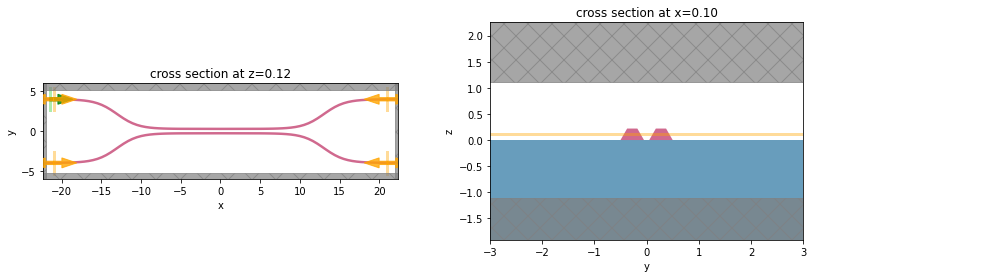

In [6]:
# visualize geometry
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sim.plot(z=wg_height/2+0.01, ax=ax1);
sim.plot(x=0.1, ax=ax2);
ax2.set_xlim([-3, 3])
plt.show()    

## Create and Submit Job

The [Job](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.web.container.Job.html) object provides an interface for managing simulations.

`job = Job(simulation)` will create a job and upload the simulation to our server to run.

Then, one may call various methods of `job` to monitor progress, download results, and get information.

For more information, refer to the API reference.

In [7]:
# create job, upload sim to server to begin running
job = web.Job(simulation=sim, task_name='CouplerVerify')

# download the results and load them into a simulation
sim_data = job.run(path='data/sim_data.hdf5')

Output()

Output()

Output()

Output()

Output()

## Postprocessing

The following function takes a completed simulation (with data loaded into it) and computes the quantities of interest.

For this case, we measure both the total transmission in the right ports and also the ratio of power between the top and bottom ports.

In [8]:
def measure_transmission(sim_data):
    """ Constructs a "row" of the scattering matrix when sourced from top left port """

    input_amp = sim_data['in'].amps.sel(direction='+')
    
    amps = np.zeros(4, dtype=complex)
    directions = ('-', '-', '+', '+')
    for i, (monitor, direction) in enumerate(zip(sim_data.simulation.monitors[:4], directions)):
        amp = sim_data[monitor.name].amps.sel(direction=direction)
        amp_normalized = amp / input_amp
        amps[i] = np.squeeze(amp_normalized.values)
    
    return amps

In [9]:
# monitor and test out the measure_transmission function the results of the single run
amps_arms = measure_transmission(sim_data)
print('mode amplitudes in each port: \n')
for amp, monitor in zip(amps_arms, sim_data.simulation.monitors[:-1]):
    print(f'\tmonitor     = "{monitor.name}"')
    print(f'\tamplitude^2 = {abs(amp)**2:.2f}')
    print(f'\tphase       = {(np.angle(amp)):.2f} (rad)\n')

mode amplitudes in each port: 

	monitor     = "in"
	amplitude^2 = 0.00
	phase       = -1.16 (rad)

	monitor     = "refect_bottom"
	amplitude^2 = 0.00
	phase       = 0.60 (rad)

	monitor     = "top"
	amplitude^2 = 0.97
	phase       = 0.32 (rad)

	monitor     = "bottom"
	amplitude^2 = 0.02
	phase       = 1.89 (rad)



<Figure size 1152x216 with 2 Axes>

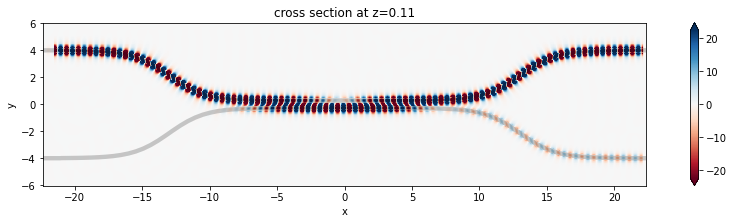

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
# sim_data['field'].Ey.real.interp(z=0).plot()
sim_data.plot_field('field', 'Ey', z=wg_height/2, freq=freq0, ax=ax)
plt.show()

## 1D Parameter Scan

Now we will scan through the coupling length parameter to see the effect on splitting ratio.

To do this, we will create a list of simulations corresponding to each parameter combination.

We will use this list to create a [Batch](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.web.container.Batch.html) object, which has similar functionality to [Job](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.web.container.Job.html) but allows one to manage a *set* of jobs.

First, we create arrays to store the input and output values.

In [11]:
# create variables to store parameters, simulation information, results
Nl = 11

ls = np.linspace(5, 12, Nl)
split_ratios = np.zeros(Nl)
efficiencies = np.zeros(Nl)

### Create Batch

We now create our list of simulations and use them to initialize a [Batch](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.web.container.Batch.html).

For more information, refer to the API reference.

In [12]:
# submit all jobs
sims = {f'l={l:.2f}' : make_sim(l, wg_spacing_coup) for l in ls}
batch = web.Batch(simulations=sims)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

### Monitor Batch

Here we can perform real-time monitoring of how many of the jobs in the batch have completed.

In [13]:
batch_results = batch.run(path_dir='data')

[16:45:39] Started working on Batch.                                         ]8;id=229664;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=454184;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/container.py#384\384]8;;\

Output()

[16:50:44] Batch complete.                                                   ]8;id=566430;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=843266;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/container.py#405\405]8;;\

### Load and visualize Reults

Finally, we can compute the output quantities and load them into the arrays we created initally.

Then we may plot the results.

In [14]:
amps_batch = []
for task_name, sim_data in batch_results.items():
    amps_arms_i = np.array(measure_transmission(sim_data))
    amps_batch.append(amps_arms_i)
amps_batch = np.stack(amps_batch, axis=1)
print(amps_batch.shape) # (4, num_freqs)
print(amps_batch)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

(4, 11)
[[ 1.06298468e-02-1.99378491e-02j  8.02398073e-03-1.97936523e-02j
   1.05311830e-02-2.36576224e-02j  1.75104295e-02-1.46165821e-02j
   1.08674508e-02-2.60412575e-02j  7.64328670e-03-1.01263247e-02j
   2.25508322e-02-2.26424108e-02j  4.82513902e-05-2.27543933e-02j
   1.78356978e-02-1.25398567e-02j  1.10857269e-02-2.68290851e-02j
   1.07438535e-02-1.89892085e-02j]
 [ 7.40022116e-03+2.92804849e-03j -2.51813672e-03-8.29557603e-03j
  -1.39052153e-03+1.50436878e-02j  6.67990710e-03-6.80094674e-03j
  -7.42048531e-03+2.40167816e-03j  8.64911550e-03+4.86721420e-03j
  -3.60153428e-03+9.65963621e-04j  9.55525519e-04+2.05731684e-04j
   1.24902833e-03+3.44426000e-03j  4.51199305e-03-3.69917633e-04j
  -9.33921481e-03+4.29490460e-03j]
 [-3.39899554e-01+4.80541719e-01j  4.22731377e-01+5.60334341e-01j
   7.52872694e-01-2.69140715e-01j -3.62240472e-02-8.78632156e-01j
  -9.08017834e-01-2.40409773e-01j -5.21665507e-01+8.27099562e-01j
   6.37223805e-01+7.63310539e-01j  9.14056174e-01-3.73521075e-01

In [15]:
powers = abs(amps_batch)**2
power_top = powers[2]
power_bot = powers[3]
power_out = power_top + power_bot

<Figure size 432x288 with 1 Axes>

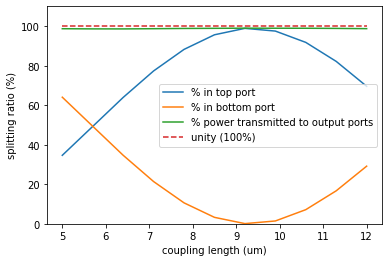

In [16]:
plt.plot(ls, 100*power_top, label='% in top port')
plt.plot(ls, 100*power_bot, label='% in bottom port')
plt.plot(ls, 100*power_out, label='% power transmitted to output ports')
plt.plot(ls, 100*np.ones_like(ls), '--', label='unity (100%)')
plt.xlabel('coupling length (um)')
plt.ylabel('splitting ratio (%)')
plt.ylim(0, 110)
plt.legend()
plt.show()

### Final Remarks

Batches provide some other convenient functionality for managing large numbers of jobs.

For example, one can save the batch information to file and load the batch at a later time, if needing to disconnect from the service while the jobs are running.

In [17]:
# save batch metadata
batch.to_file('data/batch_data.json')

# load batch metadata into a new batch
loaded_batch = web.Batch.from_file('data/batch_data.json')

For more reference, refer to our documentation.